In [1]:
import json
import random
import os

from itertools import product
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from collections import Counter, OrderedDict
from domain import *
from helper import *

splits = ['train', 'test']
evaluation = ['I', 'SS', 'LS', 'SL', 'LL']
max_op = 20
max_op_train = 10
max_value_train = 100
max_value_test = 10000

In [2]:
split2dataset = {}
for split in splits:
    split2dataset[split] = json.load(open('expr_%s.json'%split))
    
split2symset = {}
for split in splits:
    split2symset[split] = json.load(open('sym_%s.json'%split))

# Dataset size

In [3]:
for split in splits:
    dataset = split2dataset[split]
    print(f'{split}: {len(dataset)}', end=' ')
    if split != 'train':
        counts = Counter([x['eval'] for x in split2dataset[split]])
        total_count = sum(counts.values())
        for e in evaluation:
            c = counts[e]
            p = round(c/total_count*100, 2)
            print(f'{e}: {c} ({p}%)', end=' ')
    print()

train: 998000 
test: 46620 I: 9980 (21.41%) SS: 8000 (17.16%) LS: 10000 (21.45%) SL: 8640 (18.53%) LL: 10000 (21.45%) 


In [4]:
print(dataset[0])

{'id': 'test_00000000', 'img_paths': ['7/exp60078.jpg'], 'expr': '7', 'head': [-1], 'res': 7, 'res_all': [7], 'eval': 'I'}


# Symbol Distribution

Observations:
The test split SL has a much higher ratio of * than others

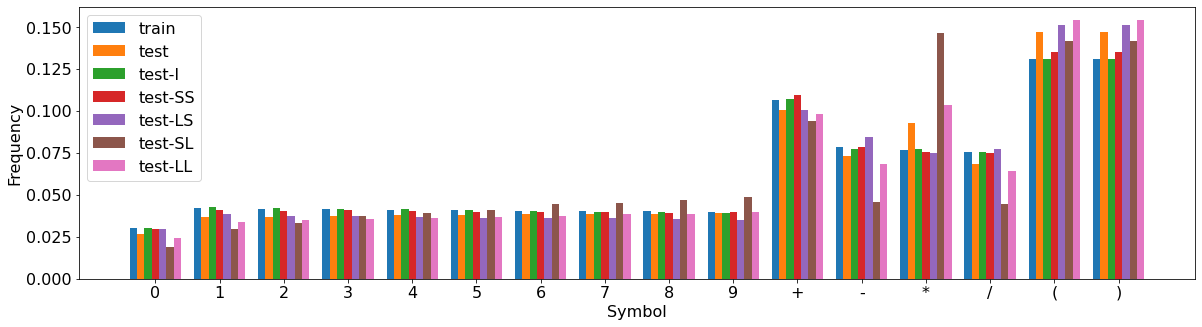

In [5]:
show_subsplit = True
bar_keys = SYMBOLS

def sample2bar_key(sample):
    r = sample['expr']
    return r

# Set general font size
plt.rcParams['font.size'] = '16'
fig, ax = plt.subplots(figsize=(20, 5))

# Set tick font size
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(16)

data_bars = OrderedDict()
for split in splits:
    dataset = split2dataset[split]
    all_points = [sample2bar_key(x) for x in dataset]
    all_points = [y for x in all_points for y in x]
    counts = Counter(all_points)
    total = len(all_points)
    freqs = [counts[x]/total for x in bar_keys]
    data_bars[split] = freqs
    if split != 'train' and show_subsplit:
        for e in evaluation:
            all_points = [sample2bar_key(x) for x in dataset if x['eval'] == e]
            all_points = [y for x in all_points for y in x]
            counts = Counter(all_points)
            total = len(all_points)
            freqs = [counts[x]/total for x in bar_keys]
            data_bars[split + '-' + e] = freqs
        
    
bar_plot(ax, data_bars)
pos = np.arange(len(freqs))
plt.xticks(pos, bar_keys)
plt.xlabel('Symbol')
plt.ylabel('Frequency')
plt.show()

# Length distribution

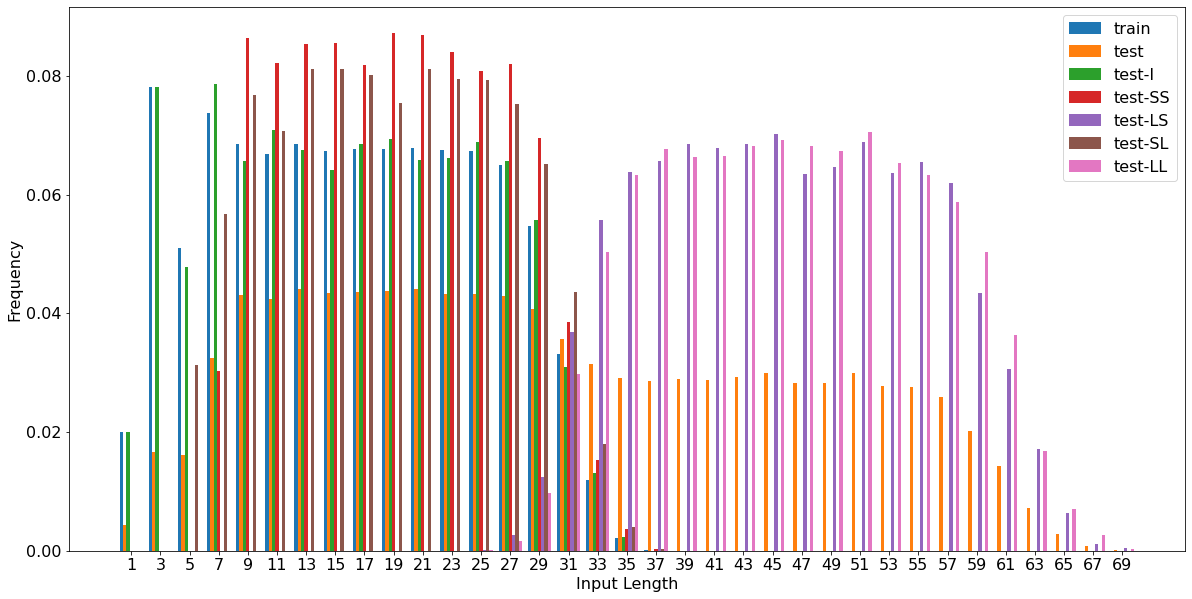

In [6]:
show_subsplit = True

max_len = max(len(x['expr']) for x in split2dataset['test'])
bar_keys = list(range(1, max_len+1, 2))

def sample2bar_key(sample):
    r = len(sample['expr'])
    return r

# Set general font size
plt.rcParams['font.size'] = '16'
fig, ax = plt.subplots(figsize=(20, 10))

# Set tick font size
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(16)

data_bars = OrderedDict()
for split in splits:
    dataset = split2dataset[split]
    all_points = [sample2bar_key(x) for x in dataset]
    counts = Counter(all_points)
    total = len(all_points)
    freqs = [counts[x]/total for x in bar_keys]
    data_bars[split] = freqs
    if split != 'train' and show_subsplit:
        for e in evaluation:
            all_points = [sample2bar_key(x) for x in dataset if x['eval'] == e]
            counts = Counter(all_points)
            total = len(all_points)
            freqs = [counts[x]/total for x in bar_keys]
            data_bars[split + '-' + e] = freqs
        

# data_bars = {k:v for k, v in data_bars.items() if k in ['train','test-LS']}
bar_plot(ax, data_bars)
pos = np.arange(len(freqs))
plt.xticks(pos, bar_keys)
plt.xlabel('Input Length')
plt.ylabel('Frequency')
plt.show()

# Result distribution

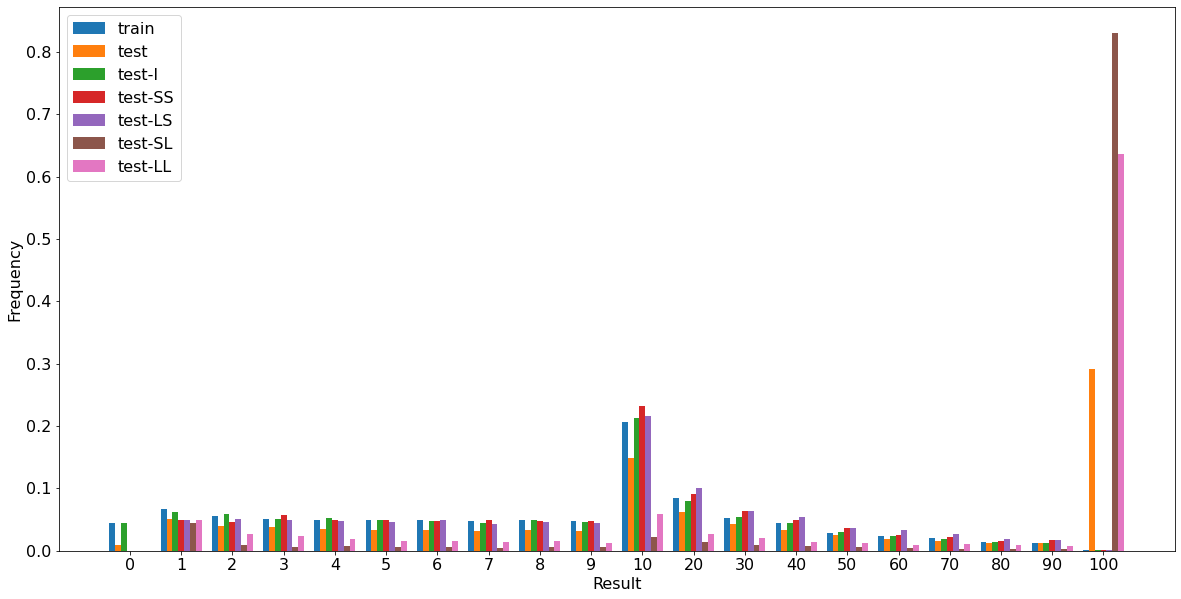

In [7]:
show_subsplit = True
bar_keys = list(range(10)) + list(np.arange(1, 11)*10)

def sample2bar_key(sample):
    r = sample['res']
    if r < 10:
        return r
    r = (r // 10) * 10
    r = min(r, 100)
    return r

# Set general font size
plt.rcParams['font.size'] = '16'
fig, ax = plt.subplots(figsize=(20, 10))

# Set tick font size
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(16)

data_bars = OrderedDict()
for split in splits:
    dataset = split2dataset[split]
    all_points = [sample2bar_key(x) for x in dataset]
    counts = Counter(all_points)
    total = len(all_points)
    freqs = [counts[x]/total for x in bar_keys]
    data_bars[split] = freqs
    if split != 'train' and show_subsplit:
        for e in evaluation:
            all_points = [sample2bar_key(x) for x in dataset if x['eval'] == e]
            counts = Counter(all_points)
            total = len(all_points)
            freqs = [counts[x]/total for x in bar_keys]
            data_bars[split + '-' + e] = freqs
        
    
bar_plot(ax, data_bars)
pos = np.arange(len(freqs))
plt.xticks(pos, bar_keys)
plt.xlabel('Result')
plt.ylabel('Frequency')
plt.show()

# Tree depth

In [8]:
from functools import lru_cache

def compute_tree_depth(head):
    @lru_cache
    def depth(i):
        """The depth of node i."""
        if head[i] == -1:
            return 1
        return depth(head[i]) + 1
    
    return max(depth(i) for i in range(len(head)))

sample = split2dataset['test'][5000]
print(sample['expr'], sample['head'], compute_tree_depth(sample['head']))

7/2*(9*5) [1, 3, 1, -1, 6, 6, 3, 6, 6] 3


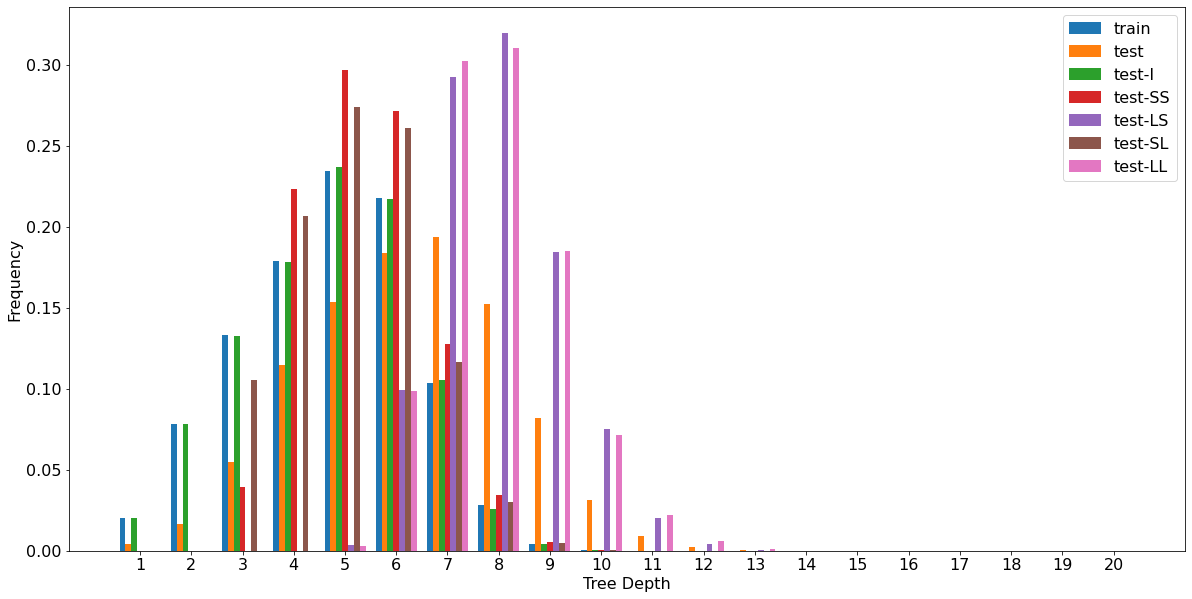

In [9]:
show_subsplit = True
bar_keys = list(range(1, max_op+1))

def sample2bar_key(sample):
    r = compute_tree_depth(sample['head'])
    return r

# Set general font size
plt.rcParams['font.size'] = '16'
fig, ax = plt.subplots(figsize=(20, 10))

# Set tick font size
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(16)

data_bars = OrderedDict()
for split in splits:
    dataset = split2dataset[split]
    all_points = [sample2bar_key(x) for x in dataset]
    counts = Counter(all_points)
    total = len(all_points)
    freqs = [counts[x]/total for x in bar_keys]
    data_bars[split] = freqs
    if split != 'train' and show_subsplit:
        for e in evaluation:
            all_points = [sample2bar_key(x) for x in dataset if x['eval'] == e]
            counts = Counter(all_points)
            total = len(all_points)
            freqs = [counts[x]/total for x in bar_keys]
            data_bars[split + '-' + e] = freqs
        
    
bar_plot(ax, data_bars)
pos = np.arange(len(freqs))
plt.xticks(pos, bar_keys)
plt.xlabel('Tree Depth')
plt.ylabel('Frequency')
plt.show()

## Parenthesis depth

In [10]:
lps = '('
rps = ')'

def compute_ps_depth(expr):
    depth = 0
    max_depth = 0
    for x in expr:
        if x == lps:
            c = 1
        elif x == rps:
            c = -1
        else:
            c = 0
        depth += c
        if depth > max_depth:
            max_depth = depth
    return max_depth



print(compute_ps_depth('1*2*(1+2*((3+4)+(3-1))'))

3


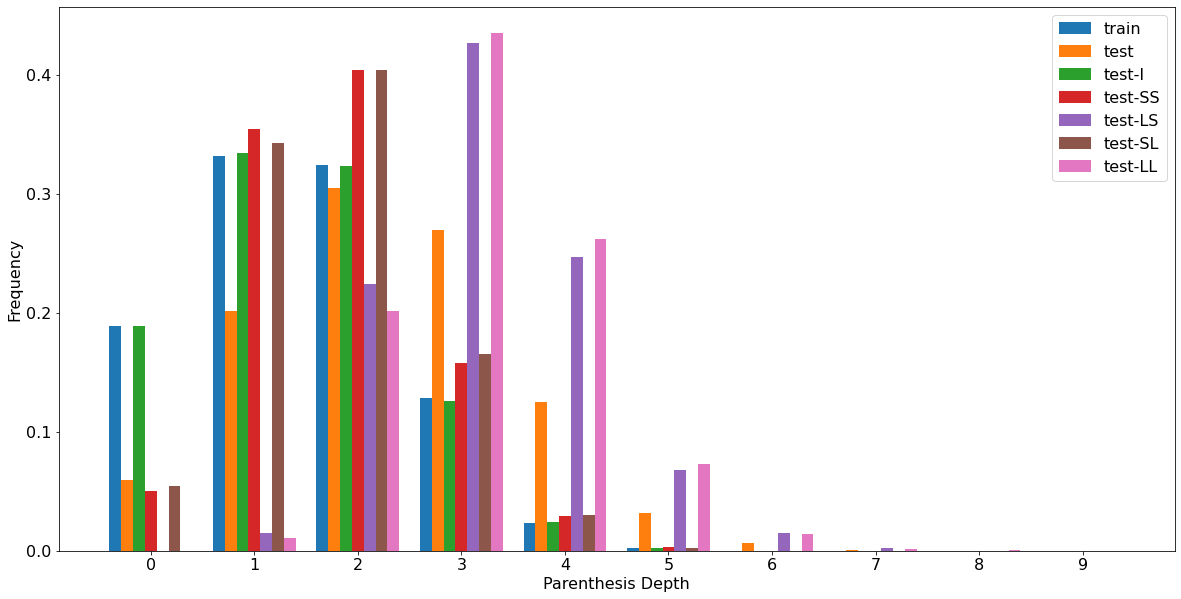

In [11]:
show_subsplit = True
bar_keys = list(range(10))

def sample2bar_key(sample):
    r = compute_ps_depth(sample['expr'])
    return r

# Set general font size
plt.rcParams['font.size'] = '16'
fig, ax = plt.subplots(figsize=(20, 10))

# Set tick font size
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(16)

data_bars = OrderedDict()
for split in splits:
    dataset = split2dataset[split]
    all_points = [sample2bar_key(x) for x in dataset]
    counts = Counter(all_points)
    total = len(all_points)
    freqs = [counts[x]/total for x in bar_keys]
    data_bars[split] = freqs
    if split != 'train' and show_subsplit:
        for e in evaluation:
            all_points = [sample2bar_key(x) for x in dataset if x['eval'] == e]
            counts = Counter(all_points)
            total = len(all_points)
            freqs = [counts[x]/total for x in bar_keys]
            data_bars[split + '-' + e] = freqs
        
    
bar_plot(ax, data_bars)
pos = np.arange(len(freqs))
plt.xticks(pos, bar_keys)
plt.xlabel('Parenthesis Depth')
plt.ylabel('Frequency')
plt.show()

# Visualize rendered images

train ============================================================
unique images for each symbol:
[('(', 2989), (')', 2983), ('*', 450), ('+', 4082), ('-', 4516), ('/', 117), ('0', 1357), ('1', 4745), ('2', 4657), ('3', 1851), ('4', 1230), ('5', 756), ('6', 609), ('7', 564), ('8', 548), ('9', 556)]
0+5+(5-4)*9 = 14


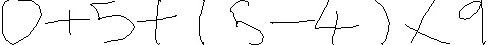

4-9-6/6+4 = 4


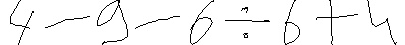

1*(9*8)+(5-(3-0)-1) = 73


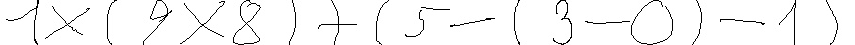

test ============================================================
unique images for each symbol:
[('(', 798), (')', 797), ('*', 120), ('+', 1089), ('-', 1205), ('/', 33), ('0', 363), ('1', 1266), ('2', 1243), ('3', 495), ('4', 329), ('5', 202), ('6', 163), ('7', 152), ('8', 147), ('9', 149)]
(4+4)*3-3+(8-0) = 29


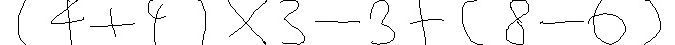

9 = 9


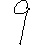

9/(5*4*6) = 1


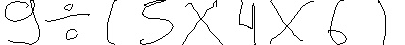

test-I============================================================
6+0*3+(3*(2+(1+5))+2-1) = 31


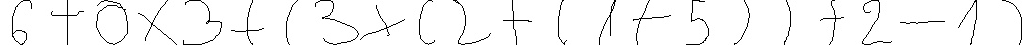

0*1*7/3+(0-1+7) = 7


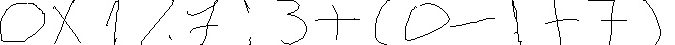

1*4*(1/9*9) = 36


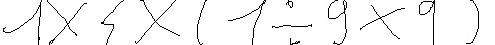

test-SS============================================================
3*(1/(9*8))*6 = 18


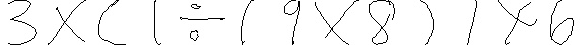

(2+6)/(0+2)*(9-8) = 4


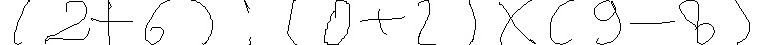

(3+4)/(5/9*6) = 2


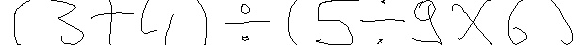

test-LS============================================================
4+7*0+(1*((1-3)*(9/7))+(9-4))*((2-0)/5)*3 = 19


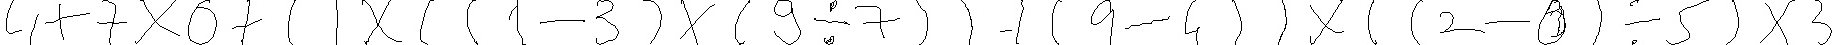

4+0-(7*0*2-(2+2*(8*4*0)/1+9/(4-0)/(9*5+5)*7/3)) = 4


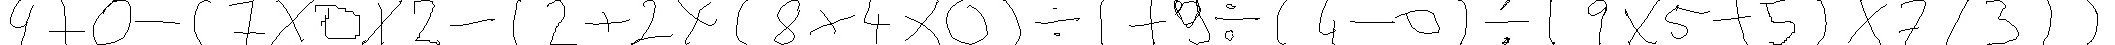

((7-(1+2))/((5+9)/8)-(6-5*8-(9-0/5)-6))*(5*7) = 70


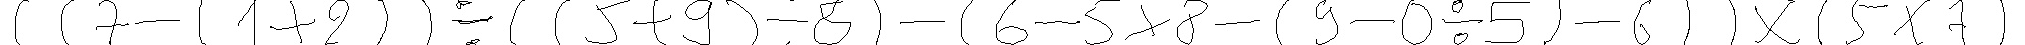

test-SL============================================================
7*(6*(9-3))-8 = 244


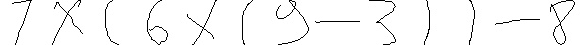

7*(0+3+(5+(7+7))) = 154


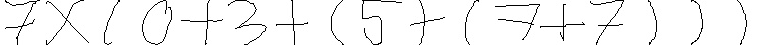

5/6*7+(9*3*6+7/7) = 170


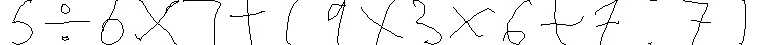

test-LL============================================================
(5*(0+7)-1)*((3+5)/(4*4/((5+2)*4+0*(1/(8+(9-0))-(6-(6+0)))))) = 272


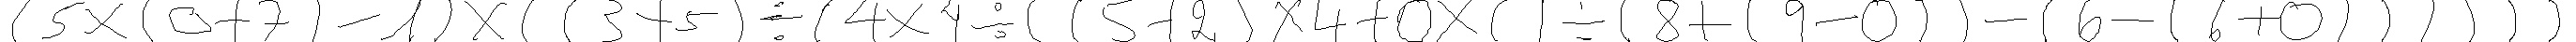

((7-6)*6-1)/(9*(6+(4-9)+(5+8)-6/2)) = 1


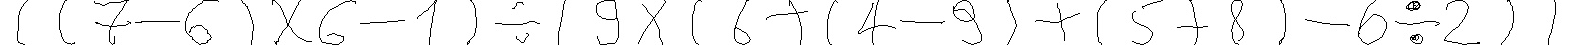

7/3*4*(1+7+1+(5/7-4))-(3-8+(8-(9+3-3))) = 108


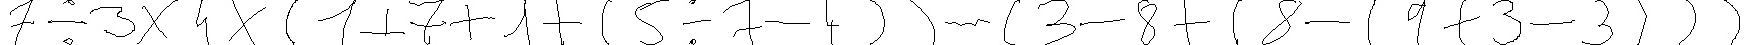

In [12]:
for split in splits:
    dataset = split2dataset[split]
    print(split, '='*60)
    print('unique images for each symbol:')
    all_images = [(x, y) for sample in dataset for x, y in zip(sample['img_paths'], sample['expr'])]
    print(sorted(Counter([x[1] for x in set(all_images)]).items()))
    for _ in range(3):
        sample = random.choice(dataset)
        img_paths = sample['img_paths']
        img = render_img(img_paths)
        print("".join(sample['expr']) + ' = ' + str(sample['res']))
        display(img)

for e in evaluation:
    print('test-' + e + '='*60)
    dataset = [x for x in split2dataset['test'] if x['eval'] == e]
    for _ in range(3):
        sample = random.choice(dataset)
        img_paths = sample['img_paths']
        img = render_img(img_paths)
        print("".join(sample['expr']) + ' = ' + str(sample['res']))
        display(img)